In [1]:
import torch
import torch.nn as nn
import torch_geometric
from src.layer.encoders import TrigonometricEncoder
from src.model.wavegc import WaveGCNet
from src.transforms.spectral import WaveGCSpectralTransform

import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: >

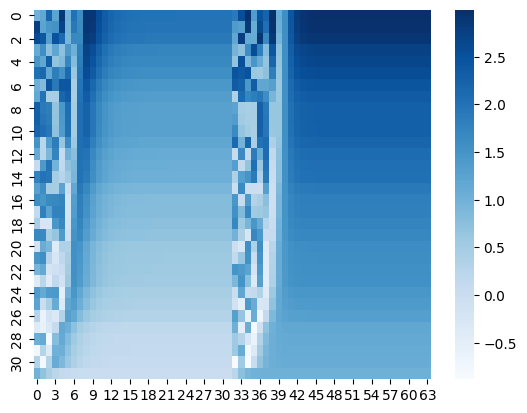

In [2]:
eigvs = torch.tensor(np.random.uniform(0,2, (1, 32) ),
                      dtype=torch.float32).sort(
    axis=1,descending=True).values
d = 64

pe = TrigonometricEncoder(d, 100, project=False)
pos = pe(eigvs)
sns.heatmap(pos.detach(), cmap='Blues')

In [3]:
from src.datasets.amazon import AmazonComputerDataset
from torch_geometric.utils.convert import to_networkx, from_networkx
import networkx as nx

In [4]:
dataset = AmazonComputerDataset(root='./data', name='Photo', threshold=0)

In [5]:
G = to_networkx(dataset._data)
G = nx.to_undirected(G)
nx.number_connected_components(G)

136

In [6]:
components = nx.connected_components(G)
for comp in components:
    print(len(comp)/G.number_of_nodes())

0.9786928104575163
0.00026143790849673205
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00026143790849673205
0.00013071895424836603
0.00026143790849673205
0.00013071895424836603
0.0005228758169934641
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00026143790849673205
0.00026143790849673205
0.00026143790849673205
0.00013071895424836603
0.00026143790849673205
0.00026143790849673205
0.00013071895424836603
0.000392156862745098
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00026143790849673205
0.00013071895424836603
0.00013071895424836603
0.0005228758169934641
0.00013071895424836603
0.00026143790849673205
0.0005228758169934641
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.000130718954248366

In [7]:
from torch.utils.data import DataLoader
from src.datasets.collate import collate_fn

In [8]:
dataset._data.y.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7])

In [9]:
loader = DataLoader(dataset=dataset, collate_fn=collate_fn, batch_size=1)

In [10]:
loader.dataset.y.unique().shape[0]

8

In [11]:
inp_dim = dataset._data.x.shape[1]
emb_dim, pe_dim = 32, 16
eigvs_dim = dataset._data.eigvs.shape[1]
hidden_dim = 32
lape_hidden_num = 1
out_dim = dataset._data.y.unique().shape[0]
K, J = 6, 3

In [12]:
import torch.nn as nn
import torch_geometric.nn as pyg_nn
from torch_geometric.nn.conv import MessagePassing

class SimpleGCN(nn.Module):
    def __init__(self, inp_dim, out_dim, hidden_dim, hidden_num=3, **kwargs):
        super().__init__()
        self.inp_dim, self.out_dim = inp_dim, out_dim
        self.hidden_dim = hidden_dim
        act = nn.GELU
        self.conv = nn.ModuleList([pyg_nn.GCN(
                                    in_channels=inp_dim,
                                    hidden_channels=hidden_dim,
                                    num_layers=hidden_num,
                                    act = act(),
                                )])
        for i in range(hidden_num):
            self.conv.append( pyg_nn.GCN(
                    in_channels=hidden_dim,
                    hidden_channels=hidden_dim,
                    num_layers=3,
                    act = act())
            )
            if i!= hidden_num-1:
                self.conv.append(nn.BatchNorm1d(hidden_dim))
                #self.conv.append(act())
        self.out = nn.Linear(hidden_dim, out_dim)
        
    def forward(self, x, edge_index, **kwargs):
        for module in self.conv: 
            if isinstance(module, (pyg_nn.GCN, MessagePassing)): 
                x = module(x, edge_index)
            else:
                x = module(x) 
                
        return self.out(x)


In [13]:
import hydra
print(hydra.__version__)

1.3.2


In [14]:
wave_flag = True

In [15]:
model = WaveGCNet(
        inp_dim=inp_dim,
        out_dim=out_dim,
        emb_dim=emb_dim, 
        pe_dim=pe_dim, 
        eigvs_dim=eigvs_dim,
        lape_hidden_num=lape_hidden_num,
        hidden_dim=hidden_dim, 
        heads_num=4,
        scale=torch.tensor([1.0]*J), 
        num_layers=4,
        mpnn="gcn",
        K=K,
        J=J,
        tight_frames=True,
        dropout=0.2,
        ffn_hidden_num=2,
        mpnn_hidden_num=1,
        eps=100,
        aggr="sum",
    ) if wave_flag else SimpleGCN(inp_dim, out_dim, hidden_dim=64)

In [16]:
print("Number of Parameters: ", sum([param.numel() for param in model.parameters()]))

Number of Parameters:  124345


In [17]:
epochs = 10
optim = torch.optim.AdamW(model.parameters(), lr=0.01)
Loss = nn.CrossEntropyLoss()

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
for epoch in tqdm(range(epochs)):
    for batch in loader:

        for key in batch:
            if key != 'eigvs':
                batch[key] = batch[key].squeeze(0)

        model.train()
        model_inputs = {
                'x': batch['x'],
                'eigvs': batch['eigvs'],
                'U': batch['U'],
                'edge_index': batch['edge_index'],
                'eigvs_mask': batch['eigvs_mask'],

            }

        logits = model(**model_inputs)[batch['train_mask']]
        target = batch['labels'][batch['train_mask']]
        loss = Loss(logits, target)

        optim.zero_grad()
        loss.backward()
        optim.step()

        train_loss.append(loss.detach().cpu().numpy())
        pred = logits.argmax(dim=1).detach().cpu().numpy()
        
        train_accuracy.append(np.mean((pred == target.cpu().numpy())))

        model.eval()
            
        logits = model(**model_inputs)[batch['test_mask']]

        target = batch['labels'][batch['test_mask']]
        loss = Loss(logits, target)

        test_loss.append(loss.detach().cpu().numpy())
        pred = logits.argmax(dim=1).detach().cpu().numpy()
        
        test_accuracy.append(np.mean((pred == target.cpu().numpy())))
        


_, ax = plt.subplots(1,2)

ax[0].plot(np.arange(epochs)+1, train_loss, c='r')
ax[0].plot(np.arange(epochs)+1, test_loss, c='g')


ax[1].plot(np.arange(epochs)+1, train_accuracy, c='r')
ax[1].plot(np.arange(epochs)+1, test_accuracy, c='g')


plt.grid()

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
from torchmetrics.classification import MulticlassAccuracy

In [ ]:
metric = MulticlassAccuracy(num_classes=None, average='micro')

In [ ]:
target, pred = torch.tensor([1,1,1], dtype=torch.long), torch.tensor([1,2,1], dtype=torch.long)

In [ ]:
metric(target, pred)

tensor(0.6667)

In [ ]:
import torch
import numpy as np
from typing import Optional
from src.metrics.base_metric import BaseMetric


class MaskedAccuracy(BaseMetric):
    def __init__(self, metric, device, *args, **kwargs):
        """
        Example of a nested metric class. Applies metric function
        object (for example, from TorchMetrics) on tensors.

        Notice that you can define your own metric calculation functions
        inside the '__call__' method.

        Args:
            metric (Callable): function to calculate metrics.
            device (str): device for the metric calculation (and tensors).
        """
        super().__init__(*args, **kwargs)
        if device == "auto":
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.metric = metric.to(device)

    def __call__(self, logits: torch.Tensor, labels: torch.Tensor, mask: Optional[torch.Tensor] = None, **kwargs):
        """
        Metric calculation logic.

        Args:
            logits (Tensor): model output predictions.
            labels (Tensor): ground-truth labels.
            mask (Tensor|None): loss mask.
        Returns:
            metric (float): calculated metric.
        """
        classes = logits.argmax(dim=-1).to(torch.long)
        return self.metric(classes[mask], labels[mask]) if mask is not None else self.metric(classes, labels)


In [ ]:
logit = torch.randn((3, 8))
target = torch.tensor([1,2,3]).to(torch.long)
acc = MaskedAccuracy(MulticlassAccuracy(num_classes=None, average='micro'), device='cpu')
acc(logits=logit, labels=target)

tensor(0.3333)

In [ ]:
target

tensor([1, 2, 3])

In [ ]:
logit.argmax(-1)

tensor([5, 2, 2])

In [ ]:
target

tensor([1, 2, 3])

ValueError: Either `preds` and `target` both should have the (same) shape (N, ...), or `target` should be (N, ...) and `preds` should be (N, C, ...).